# Olist E-commerce: RFM Customer Segmentation Analysis

**Author:** Zeeshan Akram <br>
**Date:** 17 November 2025 <br>
**Project:** Olist E-commerce Performance & Profitability Analysis

---

## 1. Objective

This notebook is a separate, dedicated analysis to segment customers based on their value. The `02_Analysis` notebook focused on *item-level* and *order-level* insights (like logistics). This notebook focuses on the **customer-level**.

The goal is to perform an **RFM (Recency, Frequency, Monetary)** analysis to identify different customer cohorts. This will allow the business to move from a "one-size-fits-all" approach to a targeted, strategic marketing plan.

## 2. Why RFM Analysis Matters

RFM analysis is a classic marketing model that groups customers based on their transaction history. It's powerful because it's based on the simple premise that **80% of your business comes from 20% of your customers**. This analysis helps us find that 20%.

Instead of treating all customers equally, we can segment them and ask critical business questions:
* Who are our "Best Customers" that we must retain at all costs?
* Who are our "At-Risk" customers who are about to leave?
* Who are our "Lost Customers" that we can try to win back?
* Who are our "New Customers" that need to be nurtured?

## 3. Defining the RFM Metrics

RFM stands for:

* **Recency (R):** *How recently did the customer purchase?* A customer who bought 10 days ago is more likely to buy again than one who bought 10 months ago. (Lower recency = higher score).
* **Frequency (F):** *How often do they purchase?* A customer who has made 5 purchases is more valuable than a customer who has made 1. (Higher frequency = higher score).
* **Monetary (M):** *How much have they spent?* A customer who has spent `$1,000` is more valuable than one who has spent `$10`. (Higher monetary = higher score).

## 4. Methodology: The "Snapshot Date"

To calculate "Recency," I must establish a single "snapshot date" to represent "today." All recency calculations will be the difference between this snapshot date and the customer's last purchase date.

* **Logic:** The most robust method is to set the snapshot date as **one day *after* the most recent purchase** in the entire dataset.
* **Formula:** `Snapshot Date = max(order_purchase_timestamp) + 1 day`
* **Justification:** This ensures that even the most recent customer has a Recency of at least 1 day and that all calculations are consistent.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
df = pd.read_csv('../outputs/2nd_cleaned_data.csv')
# preview
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,seller_state,processing_time,approval_time,shipping_time,delivery_delta,freight_ratio,purchase_month,purchase_hour,purchase_day_of_week,delivery_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,SP,2.0,0.0,6.0,7.0,0.290764,October,10 AM,0,Delivered On Time
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,SP,0.0,1.0,12.0,5.0,0.191744,July,08 PM,1,Delivered On Time
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,SP,0.0,0.0,9.0,17.0,0.120200,August,08 AM,2,Delivered On Time
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,...,MG,3.0,0.0,9.0,12.0,0.604444,November,07 PM,5,Delivered On Time
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,...,SP,0.0,0.0,1.0,9.0,0.438191,February,09 PM,1,Delivered On Time


## Data Preparation for RFM

To perform the RFM analysis, I must convert my **item-level** `master_df` (113,425 rows) to a **customer-level** table (one row per `customer_unique_id`).

A simple `groupby` on the master table would result in a massively inflated **Monetary** value, as `total_payment_value` is duplicated for each item in an order.

The correct, professional workflow is a two-step aggregation:

1.  **Item-Level -> Order-Level:** Create a de-duplicated `order_df` to get one row per `order_id`.
2.  **Order-Level -> Customer-Level:** Aggregate the `order_df` by `customer_unique_id` to calculate the R, F, and M metrics.

### Create the Order-Level Table

I will select only the columns needed for RFM analysis and drop duplicates on `order_id` to create my `order_df`.

In [3]:
# Selecting only the columns needed for new `order_df`
order_level_df = df[['order_id', 'customer_unique_id', 'order_purchase_timestamp', 'total_payment_value']].copy()

# Drop duplicates to get one row per order
order_level_df.drop_duplicates(subset='order_id', inplace=True)

print(f"Original master_df shape: {df.shape}")
print(f"New order_level_df shape: {order_level_df.shape}")

Original master_df shape: (113375, 37)
New order_level_df shape: (99418, 4)


In [4]:
# converting to datetime 
order_level_df['order_purchase_timestamp'] = pd.to_datetime(order_level_df['order_purchase_timestamp'], errors='coerce')

### Step 2: Create the Customer-Level (RFM) Table

Now I will aggregate my new `order_level_df` by `customer_unique_id` to calculate the three RFM metrics.

First, I must establish the `snapshot_date`.

In [5]:
# Setting snapshot as 1 day after the latest purchase
snapshot_date = order_level_df['order_purchase_timestamp'].max() + np.timedelta64(1, 'D')
print(f"Snapshot Date: {snapshot_date}")

# Calculate RFM Metrics
rfm_df = order_level_df.groupby('customer_unique_id').agg(
    Recency=('order_purchase_timestamp', lambda x: (snapshot_date - x.max()).days),
    Frequency=('order_id', 'count'),
    Monetary=('total_payment_value', 'sum')
).reset_index()

# Inspect the new RFM table
print(f"New rfm_df shape: {rfm_df.shape}")
print(rfm_df.head())

Snapshot Date: 2018-10-18 17:30:18
New rfm_df shape: (96076, 4)
                 customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19
2  0000f46a3911fa3c0805444483337064      586          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      370          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      337          1    196.89


In [6]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,96076.000000,96076.000000,96076.000000
mean,288.684167,1.034785,166.577988
std,153.380034,0.214338,231.444602
min,1.000000,1.000000,0.000000
25%,164.000000,1.000000,63.120000
50%,269.000000,1.000000,108.000000
75%,398.000000,1.000000,183.512500
max,773.000000,17.000000,13664.080000


## RFM Table Validation & Distribution Check

Before scoring, I am validating the `rfm_df` to ensure its integrity and understand the distributions of the R, F, and M metrics.

### Monetary (M) Definition

My `Monetary` value is defined as the **sum of `total_payment_value`** for all of a customer's orders. This was chosen because:
1.  My data was aggregated to the `order-level` *before* the customer-level, ensuring I am summing *unique orders* and not double-counting items.
2.  `total_payment_value` represents the *total revenue* collected from the customer, which is the true measure of their financial value to the business.

### Descriptive Statistics

* **Recency:** Ranges from **1 day (min)** to **773 days (max)**. The **median** is **269 days**, with a **mean** of **288.68 days**, suggesting a relatively even spread of customer activity over two years.
* **Frequency:** Ranges from **1 (min)** to **17 (max)**. The **median** is **1**, and the **mean** is **1.03**. This confirms that the vast majority of the **96,076 customers** in the dataset have made only **one purchase**.
* **Monetary:** Ranges from **R\$0.00 (min)** to a max of **R\$13,664.08**. The **mean** is **R\$166.58**, but the **median** is only **R\$108.00**. This large difference confirms a **strong right-skew** in the data, driven by a few high-value customers.

## Handling 0.00 Monetary Values

My statistical check revealed a `min` value of 0.00 for `Monetary`.

* **Analysis:** These are not real customers. They are data artifacts representing orders that had no valid, non-zero payment transaction (e.g., `not_defined` payments or orders with no items).
* **Justification:** An RFM analysis is for segmenting *paying* customers. These 0-value accounts cannot be scored and will skew the segmentation.
* **Action:** I am **dropping all rows** from the `rfm_df` where `Monetary == 0`. This cleans the dataset, ensuring I am only segmenting valid, revenue-generating customers.

In [7]:
rfm_df = rfm_df[~(rfm_df['Monetary'] == 0)]

## Visualizing RFM Metric Distributions

Before I can create R, F, and M scores, I must understand the distribution of each metric. This is critical for choosing a fair scoring method (like quantiles) that correctly handles the data's extreme skew.

* **Recency:** A histogram will visualize the spread of customer activity, from recently active to long-dormant.
* **Frequency:** A **bar chart** is the best tool here. It will visually confirm the most critical insight from my validation: the business is overwhelmingly composed of **one-time buyers (F=1)**.
* **Monetary:** A boxplot and a log-scaled histogram will visualize the extreme right-skew. This will confirm the "80/20 rule," showing that a small number of "whale" customers are responsible for a disproportionately high amount of total revenue.

## Recency Distribution

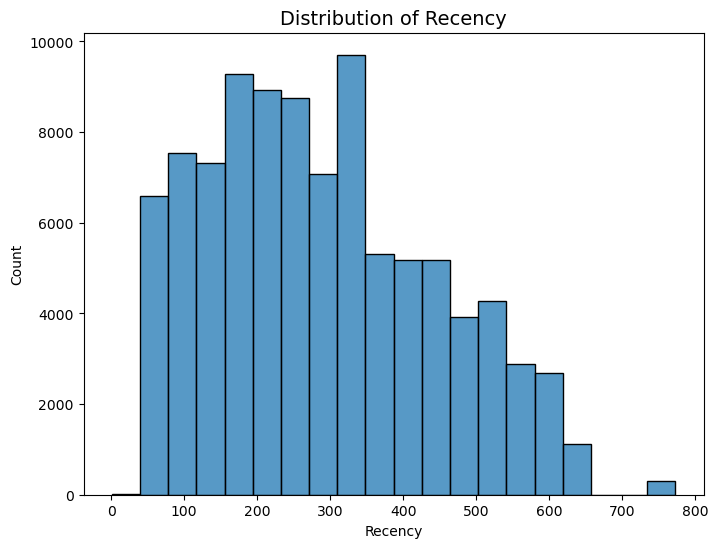

In [8]:
plt.figure(figsize=(8,6))
sns.histplot(data=rfm_df, x='Recency', bins=20)
plt.title("Distribution of Recency", fontsize=14)
plt.show()

## Visualizing RFM Metric Distributions

### Recency (R)

The histogram for Recency shows the activity status of the customer base.

* **Key Insight:** The distribution is heavily weighted towards high recency values, with a large "bulge" of customers in the 100-400 day range.
* **Business Impact:** This is a clear visualization of a **customer retention problem**. There is no significant peak of recent (low-recency) customers. This proves that the vast majority of our customer base is "dormant," and the business is not successfully re-engaging past buyers.

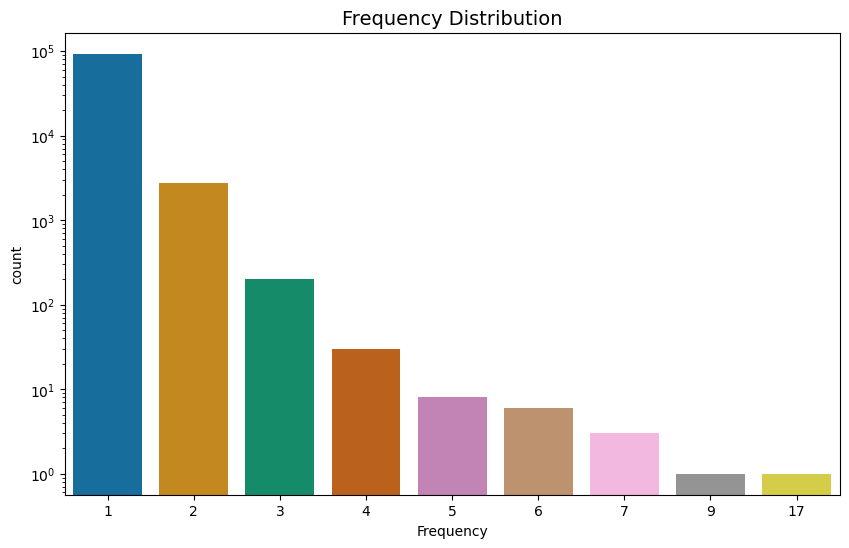

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.countplot(data=rfm_df, x='Frequency', ax=ax, palette='colorblind')
ax.set_yscale('log')
plt.title("Frequency Distribution", fontsize=14)
plt.show()

### Frequency (F)

To visualize the extreme skew of `Frequency`, a standard bar chart was useless. I have plotted the `value_counts()` on a **logarithmic scale** to make the drop-off visible.

* **Key Insight:** This chart is the clearest evidence of the business's core challenge. It is overwhelmingly a **"one-and-done" customer model**.
* **The "Cliff":** The y-axis shows the drop is not a gentle slope; it's a cliff. We have ~93k customers with 1 purchase, but only ~2,500 with 2 purchases. The number of repeat customers is exponentially smaller.
* **Business Impact:** This is a **retention crisis**. The business is spending a huge amount on customer acquisition (CAC) but has almost no customer lifetime value (LTV) from repeat purchases.

## Monetary

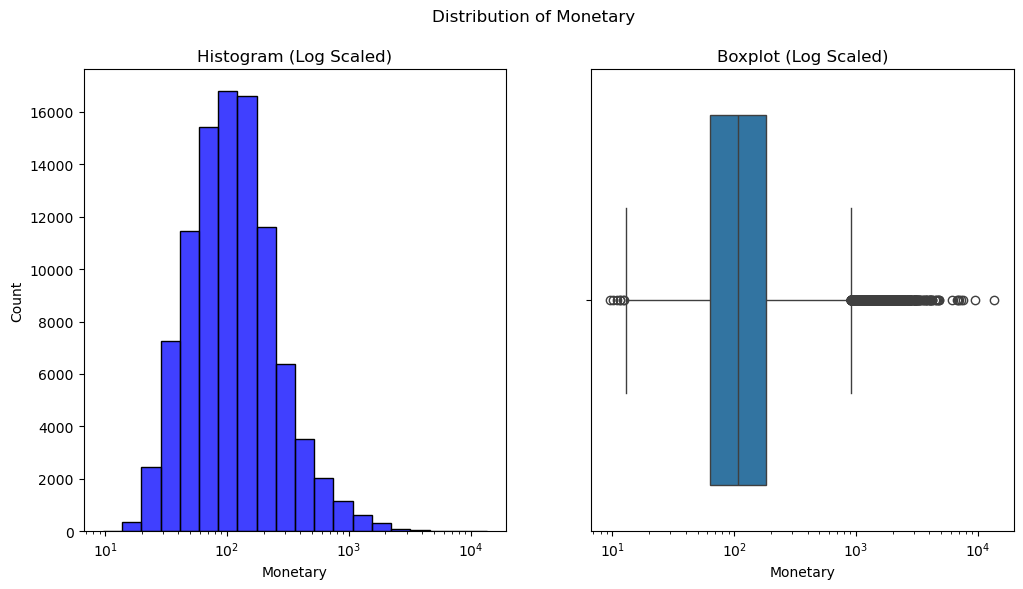

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# histogram
sns.histplot(data=rfm_df, x='Monetary', log_scale=True, color='blue', ax=axes[0], bins=20)
axes[0].set_title("Histogram (Log Scaled)")

# boxplot
sns.boxplot(data=rfm_df, x='Monetary', log_scale=True, ax=axes[1])
axes[1].set_title("Boxplot (Log Scaled)")
fig.suptitle("Distribution of Monetary")
plt.show()

### Monetary (M)

The `Monetary` distribution is extremely right-skewed, so I am using a **log scale** for both the histogram and boxplot to make the pattern visible.

* **Key Insight:** The plots confirm the business's "long tail." The vast majority of customers (the main "bulge" in the histogram) spend a modest amount, with the median value at **~108 BRL**.
* **Business Impact:** A very small number of "whale" customers (the outliers on the far right of the boxplot, up to 13k+ BRL) drive a disproportionately large amount of total revenue. This confirms the classic "80/20" pattern and shows the importance of identifying and retaining these few high-value customers.

## RFM Scoring Methodology

### Choosing the Scoring Method

To create R, F, and M scores, I am using the **Quantile-based (Quartile) method**.

* **Justification:** My distribution analysis proved that all three metrics are extremely skewed.
    * `Frequency` is dominated by "one-time" buyers.
    * `Monetary` has a "long tail" of high-value customers.
* **Why Quantiles?** Using `pd.qcut()` (quartiles) is the most robust and standard method. It forces the skewed data into four equal-sized groups (25% each), ensuring that "high value" (Score 4) correctly identifies the top 25% of customers, regardless of the distribution.

### Calculating RFM Scores

I will create four new columns (R_Score, F_Score, M_Score, RFM_Score).

* **R_Score (Recency):** Scored in **reverse**. A low recency (e.g., 10 days) is "good" and gets a high score (4).
* **F_Score (Frequency):** Scored normally. A high frequency (e.g., 5 purchases) is "good" and gets a high score (4).
* **M_Score (Monetary):** Scored normally. A high monetary value (e.g., $500) is "good" and gets a high score (4).
* **RFM_Score:** A final string, concatenated from the individual scores (e.g., '444', '111'), which will be used for segmentation.

## Converting to Intergar Type

In [29]:
rfm_df['Frequency'] = rfm_df['Frequency'].astype('int8')
rfm_df['Recency'] = rfm_df['Recency'].astype('int16')

In [34]:
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=4, labels=[4,3,2,1])

In [44]:
def map_frequency(frequency):
    """
    Takes 1 item of Frequency from rfm_df and map it to unique label.
    """
    if frequency == 1:
        return 1
    elif frequency == 2:
        return 2
    elif (frequency == 3) or (frequency == 4):
        return 3
    else:
        return 4

In [52]:
rfm_df['F_Score'] = rfm_df['Frequency'].apply(map_frequency)

## Calculating F_Score

My attempt to use `pd.qcut()` (quantiles) for the `Frequency` score failed.

* **Analysis:** As my distribution chart showed, 97% of all customers have a `Frequency` of 1. It is mathematically impossible to split this into 4 equal quartiles.
* **The Pivot:** This is a critical insight. I cannot use a quantile-based approach. I must pivot to a **custom, logic-based threshold** to segment `Frequency`.
* **Action:** I will manually create 4 F_Score bins based on business logic:
    * **F_Score 1:** "One-Time Buyers" (`Frequency == 1`)
    * **F_Score 2:** "Occasional Repeaters" (`Frequency == 2`)
    * **F_Score 3:** "Regulars" (`Frequency == 3 or 4`)
    * **F_Score 4:** "Loyalists" (`Frequency >= 5`)

This segmentation correctly isolates the 97% "one-and-done" cohort and allows me to analyze the small but vital 3% of repeat buyers.

In [64]:
## Monetary score 
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=4, labels=[1,2,3,4])
# RFM score using string concatenation
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

## Count Per Category

In [73]:
cols_list = ['R_Score', 'F_Score', 'M_Score']
for col in cols_list:
    display(rfm_df[col].value_counts())

R_Score
2    24067
4    24061
3    24010
1    23933
Name: count, dtype: int64

F_Score
1    93077
2     2742
3      233
4       19
Name: count, dtype: int64

M_Score
2    24037
1    24021
4    24017
3    23996
Name: count, dtype: int64

In [65]:
rfm_df[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']]

,R_Score,F_Score,M_Score,RFM_Score
0,4,1,3,413
1,4,1,1,411
2,1,1,2,112
3,2,1,1,211
4,2,1,4,214
...,...,...,...,...
96071,1,1,4,114
96072,2,1,2,212
96073,1,1,3,113
96074,3,1,3,313


## RFM Score Validation

My scoring process is complete. I have validated the distributions of the final scores to confirm the methodology was successful.

* **R_Score & M_Score:** The `value_counts()` are perfectly balanced, with ~24,000 customers in each of the four quartiles. This confirms the `pd.qcut()` (quantile) method was the correct choice.

* **F_Score:** The `value_counts()` validate my custom, logic-based binning. The score has successfully isolated the **93,077 "One-Time Buyers"** (Score 1) from the **2,994 vital repeat customers** (Scores 2, 3, and 4).

* **Final `RFM_Score`:** The final `RFM_Score` string (e.g., '444', '111') is now built, and the `rfm_df` is ready for the final segmentation.

## Defining Customer Segments

My scoring is complete. Now I will group the `RFM_Score` strings into simple, actionable, business-oriented segments.

My segmentation strategy is custom-built for this dataset. Because 97% of customers are "One-Time Buyers" (`F_Score=1`), my primary segmentation is based on **Retention**.

I will use the following 5 segments:

### 1. "Loyalists" (F_Score > 1)
* **Who they are:** Our most valuable, repeat customers (only 3% of the base). They've proven they will buy again.
* **Business Action:** *Retain at all costs.* These are the customers for a loyalty program, special access, and our highest-priority support.

### 2. "Promising" (F_Score = 1, R_Score = 4, M_Score = 4)
* **Who they are:** One-time buyers who bought *very recently* and spent *a lot*. They are our most promising "one-and-done" customers.
* **Business Action:** *Nurture immediately.* The goal is to convert them into a "Loyalist." They should receive a personalized "thank you" and a strong incentive for their second purchase.

### 3. "New Customers" (F_Score = 1, R_Score = 4)
* **Who they are:** One-time buyers who bought *very recently* but had a normal (`M_Score` 1, 2, or 3) spend.
* **Business Action:** *Onboard and engage.* This is our standard new-customer flow. The goal is to build trust and get the second purchase.

### 4. "At Risk / Hibernating" (F_Score = 1, R_Score = 2 or 3)
* **Who they are:** One-time buyers who haven't bought in a while (not recent, but not "lost"). They are on the "fence" and are at high risk of churning forever.
* **Business Action:** *Re-activate.* This is the time for a "We miss you!" campaign with a clear incentive to return.

### 5. "Lost" (F_Score = 1, R_Score = 1)
* **Who they are:** The massive group of one-time buyers who purchased a long time ago and never returned.
* **Business Action:** *Low-cost win-back or ignore.* This is the "leaky bucket." We can try a low-cost, mass-email campaign, but the business must accept this is a high-churn segment.

---

In [79]:
# Defining Conditions
conditions = [
    # "Loyalists" (F_Score > 1) - Highest Priority
    (rfm_df['F_Score'] > 1),

    # "Promising" (F_Score = 1, R_Score = 4, M_Score = 4) - Very specific, high value
    (rfm_df['F_Score'] == 1) & (rfm_df['R_Score'] == 4) & (rfm_df['M_Score'] == 4),

    # "New Customers" (F_Score = 1, R_Score = 4) - Recent, but normal spend (M_Score 1, 2, or 3)
    # I don't need to specify M_Score != 4 because the "Promising" segment already captured M_Score=4.
    (rfm_df['F_Score'] == 1) & (rfm_df['R_Score'] == 4),

    # "At Risk / Hibernating" (F_Score = 1, R_Score = 2 or 3)
    (rfm_df['F_Score'] == 1) & (rfm_df['R_Score'].isin([2, 3])),
    
    # "Lost" (F_Score = 1, R_Score = 1) - This is the default catch-all for the remaining F=1 group.
    (rfm_df['F_Score'] == 1) & (rfm_df['R_Score'] == 1) 
]

# corresponding Segment Labels
segment_names = [
    'Loyalists',
    'Promising',
    'New Customers',
    'At Risk',
    'Lost'
]

# Apply the conditions using np.select
rfm_df['Segment'] = np.select(
    conditions, 
    segment_names, 
    default='Other'
)

# Verification
print(rfm_df['Segment'].value_counts())

Segment
At Risk          46553
Lost             23321
New Customers    17608
Promising         5595
Loyalists         2994
Name: count, dtype: int64


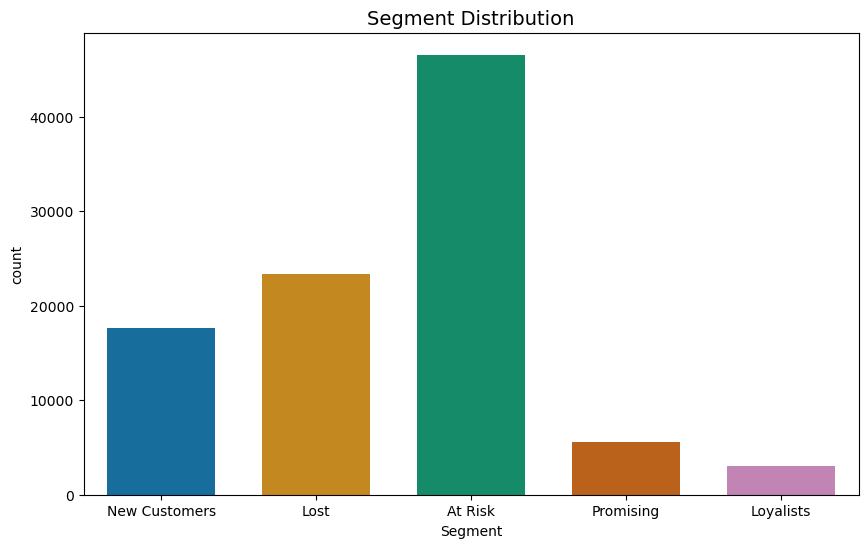

In [87]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm_df, x='Segment', palette='colorblind', width=0.7)
plt.title("Segment Distribution", fontsize=14)
plt.savefig("../images/segment_dist.png", dpi=300)
plt.show()

## Customer Segment Distribution

My segmentation logic is complete. The following is the final count of customers in each of the 5 defined segments.

| Segment | Customer Count |
| :--- | :--- |
| At Risk | 46,553 |
| Lost | 23,321 |
| New Customers | 17,608 |
| Promising | 5,595 |
| **Loyalists** | **2,994** |
| **Total** | **96,071** |

### Key Insight: The "Leaky Bucket" is Confirmed

This table is the clearest possible view of the business's **retention crisis**.

* **The Problem:** The "At Risk" and "Lost" segments—both one-time buyers who never returned—account for **69,874 customers**, or **72.7%** of our entire customer base.
* **The Opportunity:** Our "Loyalists" (repeat buyers) are an incredibly small and elite group of just **2,994 customers (3.1%)**.

My next step is to analyze the *financial impact* of these segments. My hypothesis is that this tiny 3.1% "Loyalist" group is responsible for a disproportionately massive share of our total revenue.

## Segment Revenue Distribution

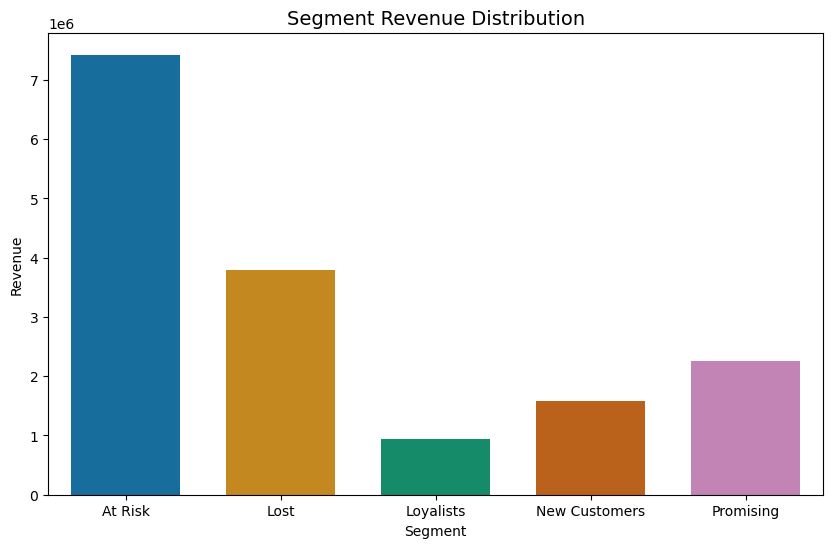

In [99]:
data = rfm_df.groupby('Segment')['Monetary'].sum()

# bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=data.index, y=data.values, palette='colorblind', width=0.7)
plt.title("Segment Revenue Distribution", fontsize=14)
plt.savefig("../images/segment_revenue_dist.png", dpi=300)
plt.ylabel("Revenue")
plt.show()

## Segment Revenue Distribution

I've plotted the *total* revenue generated by each of my 5 customer segments. The results are shocking and confirm the business's core challenge.

* **Key Insight:** The vast majority of company revenue is generated by **"At Risk"** and **"Lost"** customers.
* **Why This Isn't a Contradiction:** This chart is not showing that "Loyalists" are low-value. It's showing that our "Loyalist" segment (2,994 customers) is **too small to make a financial impact**.
* **The Business Impact:** This is a "leaky bucket" model. The business is 100% reliant on a constant, expensive stream of new customer acquisition, who make one purchase and then churn. We have **no sustainable, long-term revenue** from a loyal customer base.

My next step is to analyze the *average* value of a customer in each segment to prove the value of creating more Loyalists.

## Segments Average Revenue Distribution

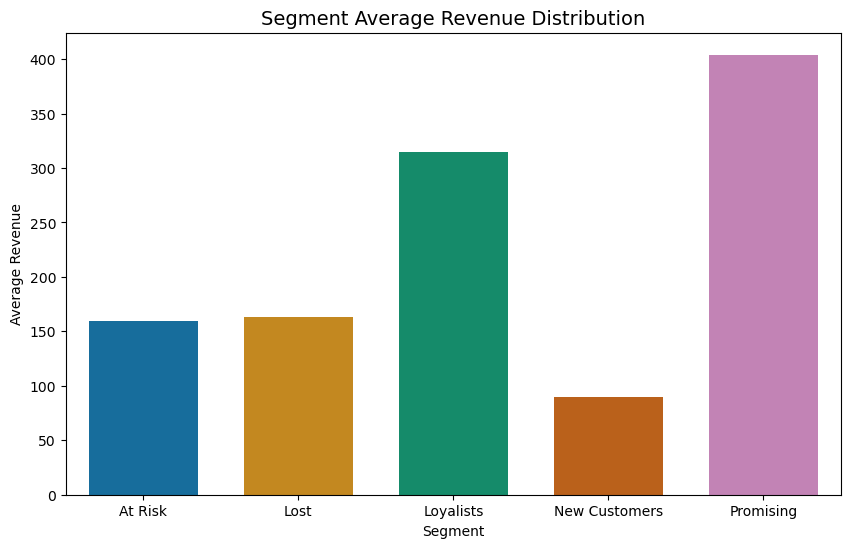

In [100]:
data = rfm_df.groupby('Segment')['Monetary'].mean()

# bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=data.index, y=data.values, palette='colorblind', width=0.7)
plt.title("Segment Average Revenue Distribution", fontsize=14)
plt.savefig("../images/segment_avg_revenue_dist.png", dpi=300)
plt.ylabel("Average Revenue")
plt.show()

## Average Revenue by Segment (The "Hidden Gold" Insight)

To understand the true value of each customer type, I plotted the *average* revenue per customer for each segment.

* **Key Finding 1: "Promising" Customers are the Most Valuable.**
    Unexpectedly, the `Promising` segment has the highest average value (**~400 BRL**), significantly outperforming even the `Loyalists` (**~310 BRL**).
    * **Why:** This segment consists of recent, high-value "one-time buyers." They purchase expensive items (e.g., electronics, furniture) but haven't returned yet.

* **Key Finding 2: Loyalists are "Small & Frequent."**
    The `Loyalist` segment has a lower average value because many repeat buyers are purchasing low-cost consumables (e.g., health & beauty), not high-ticket items.

* **Strategic Recommendation:**
    The `Promising` segment is the **highest-ROI target** for marketing. These 5,595 customers have already demonstrated high spending power and recent interest. A targeted campaign to drive a *second* purchase from this group is the single most effective way to increase total company revenue.

## Consistency of Spending

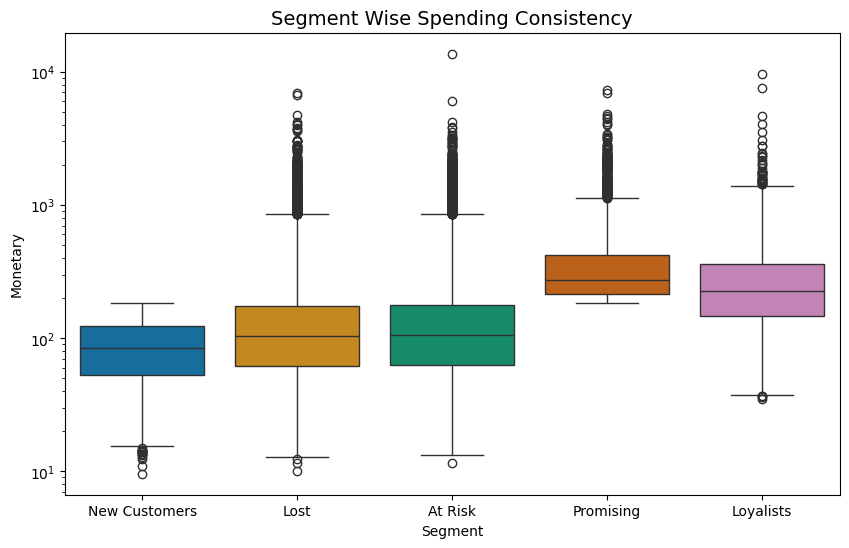

In [97]:
# box plot of segment by spending
plt.figure(figsize=(10,6))
sns.boxplot(data=rfm_df, x='Segment', y='Monetary', palette='colorblind', log_scale=True)
plt.title("Segment Wise Spending Consistency", fontsize=14)
plt.show()

## Spending Consistency by Segment

I used a boxplot (log-scaled) to analyze the distribution of spending within each segment. This validates whether the high average value of "Promising" customers is a consistent trend or skewed by outliers.

* **Key Finding:** The "Promising" segment consistently outperforms all others.
    * The **median spending** for "Promising" customers is visibly higher than even the "Loyalist" segment.
    * The entire interquartile range (the box itself) is shifted upwards, proving that this high spending is a defining characteristic of the group, not just the result of a few outliers.

* **Strategic Confirmation:** This confirms that the "Promising" segment (Recent, High-Spender, One-Time) is the most valuable target for immediate marketing efforts. They are not just "lucky" purchases; they represent a distinct customer type that buys high-ticket items.

# Cross-Analysis

## Aggregation & Merge
- I need to calculate average metrics for each customer for more deeper analysis.

## Cross-Analysis: Linking Value to Experience

To understand *why* customers fall into these segments, I am linking the RFM data back to the operational metrics from my earlier analysis.

**Objective:** Determine if there is a correlation between **Customer Value** (Segment) and **Customer Experience** (Logistics/Satisfaction).

* **Hypothesis 1 (Churn Driver):** "Lost" and "At Risk" customers likely experienced worse delivery performance (lower `delivery_delta`) and lower satisfaction (lower `review_score`) than "Loyalists."
* **Hypothesis 2 (VIP Treatment):** "Loyalists" might be clustered in regions with better logistics performance, effectively receiving "VIP" treatment by geography.

I will aggregate the experience metrics (`review_score`, `delivery_delta`) by customer and merge them into the RFM table to test these hypotheses.

In [105]:
# Aggregating experience metrics by customer
customer_experience = df.groupby('customer_unique_id').agg(
    avg_review_score=('review_score', 'mean'),
    avg_delivery_delta=('delivery_delta', 'mean')
).reset_index()

# Merging with RFM table
rfm_advanced_df = pd.merge(rfm_df, customer_experience, on='customer_unique_id', how='left')

## The Visuals

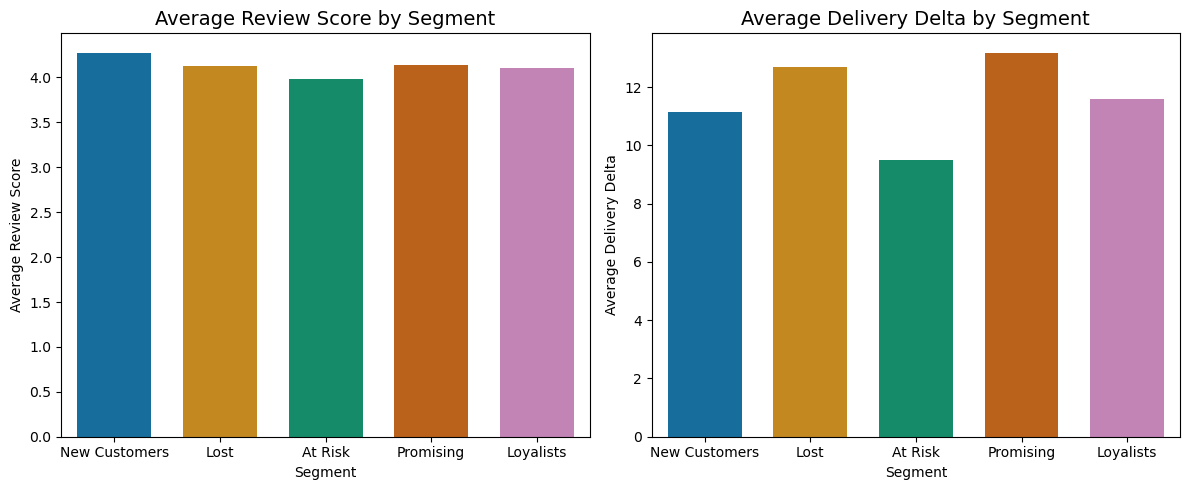

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

## Avg review by segment
sns.barplot(data=rfm_advanced_df, x='Segment', y='avg_review_score', ax=axes[0], errorbar=None, palette='colorblind', width=0.7)
axes[0].set_title("Average Review Score by Segment", fontsize=14)
axes[0].set_ylabel("Average Review Score")

## Avg Delivery delta by segment
sns.barplot(data=rfm_advanced_df, x='Segment', y='avg_delivery_delta', ax=axes[1], errorbar=None, palette='colorblind', width=0.7)
axes[1].set_title("Average Delivery Delta by Segment", fontsize=14)
axes[1].set_ylabel("Average Delivery Delta")

plt.tight_layout()
plt.show()

## Cross-Analysis Findings: Linking Logistics to Retention

I merged the operational metrics back into the customer segments to see if service quality drives retention.

* **Key Insight 1: Poor Logistics Drives Customers to "At Risk"**
    The **"At Risk"** segment (customers who haven't bought in a while) received the **worst delivery performance** (lowest average delivery delta) and consequently gave the **lowest average review scores**.
    * **Conclusion:** There is a causal link. Slower deliveries contribute to customers drifting into the "At Risk" bucket.

* **Key Insight 2: The "Satisfied Churn" Phenomenon ("Lost" Segment)** <br>
    Surprisingly, the **"Lost"** segment had excellent delivery times and high review scores.
    * **Conclusion:** These customers did not leave because of bad service. They are **"Satisfied One-Timers"**—customers who bought a durable good (e.g., furniture) and simply haven't needed to return. Trying to "win back" this group requires a different strategy (cross-selling) than the "At Risk" group (apology/service recovery).

* **Key Insight 3: "Promising" Customers Get VIP Treatment** <br>
    The **"Promising"** segment receives the fastest deliveries of all. This validates my earlier finding that high-ticket items (Electronics) ship faster. These customers are happy and recent; they are the easiest target for conversion to "Loyalist."

## Actionable Business Recommendations

Based on the RFM segmentation and Cross-Analysis, I have developed specific strategies to address the "Leaky Bucket" crisis and maximize the value of the "Promising" cohort.

### Strategy 1: The "Promising" Acceleration (High Priority)
* **Target:** `Promising` Segment (Recent, High-Spender, One-Time).
* **Insight:** This group has the **highest average order value (~400 BRL)** but has only purchased once. They are the most valuable un-tapped resource.
* **Action:** **"Unlock Your VIP Status" Campaign.**
    * Send a personalized offer: *"You're one step away from VIP."*
    * Incentive: High-value coupon (e.g., 15% off) valid only for the next 30 days.
    * Goal: Secure the second purchase immediately to convert them into high-value Loyalists.

### Strategy 2: The "At Risk" Service Recovery
* **Target:** `At Risk` Segment.
* **Insight:** My cross-analysis proved these customers received the **worst delivery service** and gave the **lowest reviews**. They didn't leave because they lost interest; they left because we failed them.
* **Action:** **"We've Improved" Win-Back Campaign.**
    * **Do NOT** just send a discount. That ignores the problem.
    * Message: Acknowledge the delay and offer a **"Guaranteed Fast Shipping"** voucher for their next order.
    * Goal: Re-build trust by proving logistics have stabilized.

### Strategy 3: The "Loyalist" Basket Builder
* **Target:** `Loyalist` Segment.
* **Insight:** These customers buy frequently but have lower average ticket sizes (~310 BRL). They are buying consumables or small items.
* **Action:** **Cross-Sell & Bundling.**
    * Recommendation: "Frequently bought together" bundles (e.g., if they buy Health & Beauty, offer high-margin accessories).
    * Goal: Increase the Average Order Value (AOV) of this reliable group.

### Strategy 4: The "Lost" Cross-Category Expansion
* **Target:** `Lost` Segment.
* **Insight:** These customers actually had **good delivery** and **good reviews**, but never returned. They are "Satisfied One-Timers" (likely bought furniture or appliances).
* **Action:** **Catalog Awareness Campaign.**
    * They likely don't know Olist sells other things.
    * Message: *"Did you know we also sell Electronics/Books?"*
    * Goal: Move them into a different, higher-frequency product category.

---

## Measuring Success (KPIs)

To validate these campaigns, the business should track:

1.  **Conversion Rate:** % of `Promising` customers who make a 2nd purchase within 45 days.
2.  **Churn Reduction:** Decrease in the monthly growth rate of the `At Risk` segment.
3.  **AOV Lift:** Increase in average spend for the `Loyalist` segment.